U-net for Self-Driving Car

## 1 Load Library

In [ ]:
!nvidia-smi

Tue Aug 22 14:37:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 1.2. Load Library

In [ ]:
import numpy as np
import pandas as pd
import imageio
import random
import shutil
import os
import glob
import hashlib
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## 2 Load Dataset

In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
MAIN_PATH = '/content/drive/MyDrive/bootcamp/data/cityscape'
TRAIN_IMAGE = os.path.join(MAIN_PATH, 'images_prepped_train')
TEST_IMAGE = os.path.join(MAIN_PATH, 'images_prepped_test')
TRAIN_MASK = os.path.join(MAIN_PATH, 'annotations_prepped_train')
TEST_MASK = os.path.join(MAIN_PATH, 'annotations_prepped_test')

In [ ]:
# Test Path
TRAIN_IMAGE

'/content/drive/MyDrive/KULIAH CV SPECIALIST/Project 3 Self Driving Car/images_prepped_train'

In [ ]:
# Cek Jumlah File di Masing-masing Folder
n_train_images = len(os.listdir(TRAIN_IMAGE))
n_test_images = len(os.listdir(TEST_IMAGE))
n_train_mask = len(os.listdir(TRAIN_MASK))
n_test_mask = len(os.listdir(TEST_MASK))

print('Total Train Image :', n_train_images, "Image")
print('Total Train Mask :', n_train_mask, "Mask")
print("")
print('Total Test Image :', n_test_images, "Image")
print('Total Test Mask :', n_test_images, "Mask")

Total Train Image : 398 Image
Total Train Mask : 367 Mask

Total Test Image : 101 Image
Total Test Mask : 101 Mask


In [ ]:
print('Selisih File Image vs Mask di Folder Train: ', n_train_images - n_train_mask, 'Mask')

Selisih File Image vs Mask di Folder Train:  31 Mask


In [ ]:
# Mengecek Ekstensi File Image
# Code berikut memerlukan library `glob` dan `os`

# Buat pola wildcard untuk ekstensi file gambar yang ingin Anda periksa
image_extensions = ["*.jpg", "*.png", "*.gif", "*.jpeg"]  # Anda dapat menambahkan ekstensi lain sesuai kebutuhan

# Inisialisasi set untuk menyimpan ekstensi file gambar yang unik
unique_extensions = set()

# Loop melalui setiap ekstensi file dan mencari file yang sesuai
for extension in image_extensions:
    image_files = glob.glob(f"{TRAIN_IMAGE}/{extension}")
    for image_file in image_files:
        _, ext = os.path.splitext(image_file)
        unique_extensions.add(ext)

# Sekarang, unique_extensions berisi ekstensi file gambar yang unik dalam folder tersebut

# Menampilkan ekstensi file gambar yang unik
print("Unique ekstensi file gambar yang ditemukan:")
for ext in unique_extensions:
    print(ext)

# Code from ChatGPT

Unique ekstensi file gambar yang ditemukan:
.png


In [ ]:
# Copy TRAIN_IMAGE kedalam Colab
# Code berikut memerlukan library shutil dan os

# Path ke folder di Google Drive
gdrive_path = TRAIN_IMAGE # Ganti dengan path folder di Google Drive

# Path ke folder baru di Google Colab
colab_path = "/content/train_image_colab"  # Ganti dengan path folder baru di Colab

# Buat folder baru di Google Colab jika belum ada
if not os.path.exists(colab_path):
    os.makedirs(colab_path)

# Meng-copy semua gambar dari folder di Drive ke folder baru di Colab
for filename in os.listdir(gdrive_path):
    if filename.endswith(".png"):
        source_path = os.path.join(gdrive_path, filename)
        target_path = os.path.join(colab_path, filename)
        shutil.copy2(source_path, target_path)

print("Gambar-gambar TRAIN_IMAGE telah di-copy ke folder baru di Colab.")

# Code from ChatGPT

Gambar-gambar TRAIN_IMAGE telah di-copy ke folder baru di Colab.


In [ ]:
# Copy TRAIN_MASK kedalam Colab
# Code berikut memerlukan library shutil dan os

# Path ke folder di Google Drive
gdrive_path = TRAIN_MASK # Ganti dengan path folder di Google Drive

# Path ke folder baru di Google Colab
colab_path = "/content/train_mask_colab"  # Ganti dengan path folder baru di Colab

# Buat folder baru di Google Colab jika belum ada
if not os.path.exists(colab_path):
    os.makedirs(colab_path)

# Meng-copy semua gambar dari folder di Drive ke folder baru di Colab
for filename in os.listdir(gdrive_path):
    if filename.endswith(".png"):
        source_path = os.path.join(gdrive_path, filename)
        target_path = os.path.join(colab_path, filename)
        shutil.copy2(source_path, target_path)

print("Gambar-gambar TRAIN_MASK telah di-copy ke folder baru di Colab.")

# Code from ChatGPT

Gambar-gambar TRAIN_MASK telah di-copy ke folder baru di Colab.


In [ ]:
# Copy TEST_IMAGE kedalam Colab
# Code berikut memerlukan library shutil dan os

# Path ke folder di Google Drive
gdrive_path = TEST_IMAGE # Ganti dengan path folder di Google Drive

# Path ke folder baru di Google Colab
colab_path = "/content/test_image_colab"  # Ganti dengan path folder baru di Colab

# Buat folder baru di Google Colab jika belum ada
if not os.path.exists(colab_path):
    os.makedirs(colab_path)

# Meng-copy semua gambar dari folder di Drive ke folder baru di Colab
for filename in os.listdir(gdrive_path):
    if filename.endswith(".png"):
        source_path = os.path.join(gdrive_path, filename)
        target_path = os.path.join(colab_path, filename)
        shutil.copy2(source_path, target_path)

print("Gambar-gambar TEST_IMAGE telah di-copy ke folder baru di Colab.")

# Code from ChatGPT

Gambar-gambar TEST_IMAGE telah di-copy ke folder baru di Colab.


In [ ]:
# Copy TEST_MASK kedalam Colab
# Code berikut memerlukan library shutil dan os

# Path ke folder di Google Drive
gdrive_path = TEST_MASK # Ganti dengan path folder di Google Drive

# Path ke folder baru di Google Colab
colab_path = "/content/test_mask_colab"  # Ganti dengan path folder baru di Colab

# Buat folder baru di Google Colab jika belum ada
if not os.path.exists(colab_path):
    os.makedirs(colab_path)

# Meng-copy semua gambar dari folder di Drive ke folder baru di Colab
for filename in os.listdir(gdrive_path):
    if filename.endswith(".png"):
        source_path = os.path.join(gdrive_path, filename)
        target_path = os.path.join(colab_path, filename)
        shutil.copy2(source_path, target_path)

print("Gambar-gambar TEST_MASK telah di-copy ke folder baru di Colab.")

# Code from ChatGPT

Gambar-gambar TEST_MASK telah di-copy ke folder baru di Colab.


In [ ]:
# Load Image yang ada di Colab
TRAIN_IMAGE_COLAB = "/content/train_image_colab"
TRAIN_MASK_COLAB = "/content/train_mask_colab"

TEST_IMAGE_COLAB = "/content/test_image_colab"
TEST_MASK_COLAB = "/content/test_mask_colab"

## 3 Exploratory Data Analysis

Contoh file duplikat:
0016E5_07830(2).png
0016E5_07830.png
0016E5_07830(1).png
0006R0_f03750.png
0006R0_f03750(1).png
0016E5_07740(1).png
0016E5_07740.png
0016E5_07740(2).png
0016E5_07620(1).png
0016E5_07620(2).png
Total file duplikat: 31


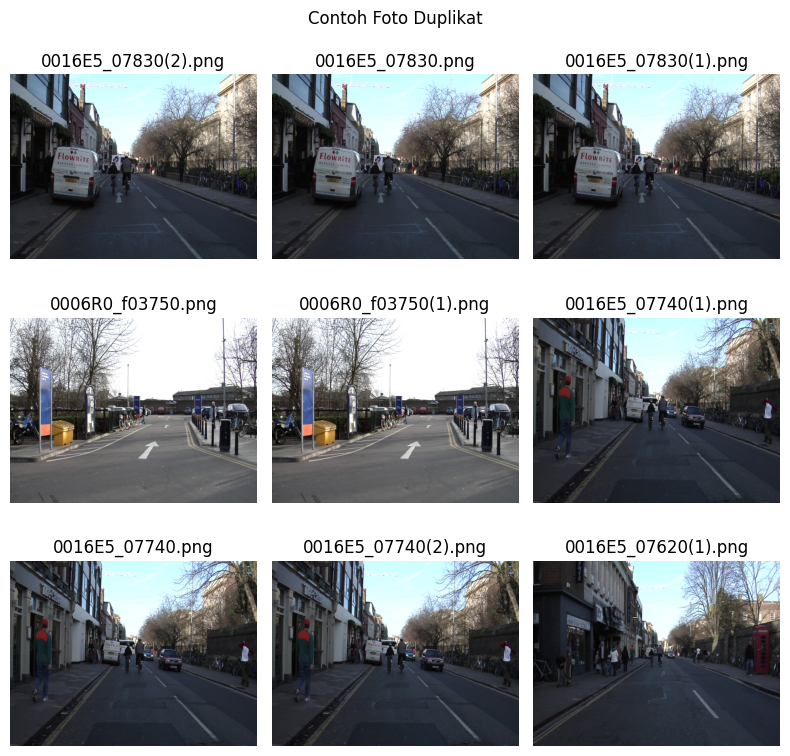

In [ ]:
# Mengecek File Duplikat pada Train Image, Menghitung Jumlahnya dan Menampilkan 5 File Contoh
# Library yang digunakan : os dan hashlib

# Mencari semua file dengan ekstensi gambar dalam folder
image_files = [file for file in os.listdir(TRAIN_IMAGE_COLAB) if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Menggunakan dictionary untuk menyimpan hash nilai dan daftar file dengan hash yang sama
duplicate_files = {}

# Memeriksa setiap file gambar
for file_name in image_files:
    file_path = os.path.join(TRAIN_IMAGE_COLAB, file_name)
    with open(file_path, 'rb') as f:
        file_hash = hashlib.md5(f.read()).hexdigest()

    if file_hash not in duplicate_files:
        duplicate_files[file_hash] = [file_name]
    else:
        duplicate_files[file_hash].append(file_name)

# Menghitung total file yang duplikat
total_duplicate_files = sum(len(files) - 1 for files in duplicate_files.values())

# Menampilkan 10 contoh nama file yang duplikat
print("Contoh file duplikat:")
count = 0
for file_list in duplicate_files.values():
    if len(file_list) > 1:
        for file_name in file_list[:10]:
            count += 1
            print(file_name)
            if count == 10:
                break
    if count == 10:
        break

# Menampilkan total file yang duplikat
print(f"Total file duplikat: {total_duplicate_files}")

# Mengumpulkan 31 contoh file yang diduga duplikat
duplicate_examples = []
for file_list in duplicate_files.values():
    if len(file_list) > 1:
        duplicate_examples.extend(file_list[:10])
    if len(duplicate_examples) >= 10:
        break

# Menampilkan 9 foto duplikat dengan judul sebagai nama file
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    if i < len(duplicate_examples):
        file_name = duplicate_examples[i]
        file_path = os.path.join(TRAIN_IMAGE_COLAB, file_name)
        image = plt.imread(file_path)
        ax.imshow(image)
        ax.set_title(file_name)
        plt.suptitle('Contoh Foto Duplikat')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Code Modif dari Chat GPT

In [ ]:
# Menghitung dan Menghapus File yang Duplikat

# Menampilkan dan Menghitung semua file yang berakhiran (1) dan (2) .png
# Code berikut memerlukan libaray os

def find_and_count_duplicate_files(TRAIN_IMAGE_COLAB):
    duplicate_files = []

    for filename in os.listdir(TRAIN_IMAGE_COLAB):
        if filename.endswith("(1).png") or filename.endswith("(2).png"):
            duplicate_files.append(filename)

    return duplicate_files

def remove_files(TRAIN_IMAGE_COLAB, file_names):
    for filename in file_names:
        file_path = os.path.join(TRAIN_IMAGE_COLAB, filename)
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"File {filename} telah dihapus.")

if __name__ == "__main__":
    duplicate_files = find_and_count_duplicate_files(TRAIN_IMAGE_COLAB)
    duplicate_count = len(duplicate_files)

    print("Daftar file yang berakhiran (1) dan (2) serta berekstensi .png:")
    for filename in duplicate_files:
        print(filename)

    print(f"Jumlah file duplikat: {duplicate_count}")

    # Menghapus File Duplikat dari Object "TRAIN_IMAGE_COLAB" di atas
    remove_files(TRAIN_IMAGE_COLAB, duplicate_files)

    # Menghitung file yang tersisa
    remaining_file_count = len(os.listdir(TRAIN_IMAGE_COLAB))
    print(f"Jumlah file tersisa setelah penghapusan: {remaining_file_count}")

# Code from ChatGPT
# Note: Jika ingin menghapus image yang diplikat langsung pada folder di GDrive,
        # maka nama Object untuk menyimpan image diganti dengan nama Object yang langsung ke GDrive path.

Daftar file yang berakhiran (1) dan (2) serta berekstensi .png:
0006R0_f03630(1).png
0016E5_05400(1).png
0006R0_f03660(1).png
0006R0_f03930(1).png
0016E5_07620(1).png
0006R0_f03750(1).png
0016E5_07920(1).png
0016E5_07740(2).png
0016E5_07710(1).png
0016E5_07770(1).png
0016E5_07860(1).png
0016E5_07830(2).png
0016E5_07620(2).png
0016E5_07800(1).png
0016E5_07800(2).png
0016E5_07680(1).png
0006R0_f03600(1).png
0016E5_07680(2).png
0016E5_07650(2).png
0016E5_07740(1).png
0016E5_07860(2).png
0016E5_07710(2).png
0016E5_07920(2).png
0016E5_07650(1).png
0016E5_07830(1).png
0016E5_07770(2).png
0006R0_f03780(1).png
0006R0_f03720(1).png
0006R0_f03840(1).png
0006R0_f03810(1).png
0006R0_f03690(1).png
Jumlah file duplikat: 31
File 0006R0_f03630(1).png telah dihapus.
File 0016E5_05400(1).png telah dihapus.
File 0006R0_f03660(1).png telah dihapus.
File 0006R0_f03930(1).png telah dihapus.
File 0016E5_07620(1).png telah dihapus.
File 0006R0_f03750(1).png telah dihapus.
File 0016E5_07920(1).png telah dihapu

In [ ]:
# Mencocokan Nama File dari Folder Train_Image_Colab vs Train_Mask_Colab
# Code barikut memerlukan library os

train_image_path1 = TRAIN_IMAGE_COLAB  # Ganti dengan path folder pertama Anda
train_mask_path2 = TRAIN_MASK_COLAB  # Ganti dengan path folder kedua Anda

def get_file_list(folder_path):
    file_list = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            file_list.append(filename)

    return file_list

if __name__ == "__main__":
    file_list1 = get_file_list(train_image_path1)
    file_list2 = get_file_list(train_mask_path2)

    different_files = []

    for filename in file_list1:
        if filename not in file_list2:
            different_files.append(filename)

    print("File yang tidak cocok antara kedua folder:")
    for filename in different_files:
        path1 = os.path.join(train_image_path1, filename)
        path2 = os.path.join(train_mask_path2, filename)
        print(f"Nama file: {filename}")
        print(f"Path di folder 1: {path1}")
        print(f"Path di folder 2: {path2}")
        print("-----------------------")

    print("Pengecekan train image dan mask selesai.")

# Code from ChatGPT

File yang tidak cocok antara kedua folder:
Pengecekan train image dan mask selesai.


In [ ]:
# Mencocokan Nama File dari Folder Test_Image_Colab vs Test_Mask_Colab
# Code barikut memerlukan library os

test_image_path1 = TEST_IMAGE_COLAB  # Ganti dengan path folder pertama Anda
test_mask_path2 = TEST_MASK_COLAB  # Ganti dengan path folder kedua Anda

def get_file_list(folder_path):
    file_list = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            file_list.append(filename)

    return file_list

if __name__ == "__main__":
    file_list1 = get_file_list(test_image_path1)
    file_list2 = get_file_list(test_mask_path2)

    different_files = []

    for filename in file_list1:
        if filename not in file_list2:
            different_files.append(filename)

    print("File yang tidak cocok antara kedua folder:")
    for filename in different_files:
        path1 = os.path.join(test_image_path1, filename)
        path2 = os.path.join(test_mask_path2, filename)
        print(f"Nama file: {filename}")
        print(f"Path di folder 1: {path1}")
        print(f"Path di folder 2: {path2}")
        print("-----------------------")

    print("Pengecekan test image dan mask selesai.")

# Code from ChatGPT

File yang tidak cocok antara kedua folder:
Pengecekan test image dan mask selesai.


In [ ]:
# Menggabungkan Image Train dan Test
# Code berikut memerlukan library Pillow dan os

# Path ke folder baru untuk hasil gabungan di Google Colab
output_image_path = "/content/merged_images"  # Ganti dengan path folder hasil gabungan di Colab

# Buat folder baru untuk hasil gabungan jika belum ada
if not os.path.exists(output_image_path):
    os.makedirs(output_image_path)

# Copy seluruh isi folder pertama ke folder baru
for filename in os.listdir(TRAIN_IMAGE_COLAB):
    source_path = os.path.join(TRAIN_IMAGE_COLAB, filename)
    target_path = os.path.join(output_image_path, filename)
    shutil.copy2(source_path, target_path)

# Copy seluruh isi folder kedua ke folder baru
for filename in os.listdir(TEST_IMAGE_COLAB):
    source_path = os.path.join(TEST_IMAGE_COLAB, filename)
    target_path = os.path.join(output_image_path, filename)
    shutil.copy2(source_path, target_path)

print("Proses penggabungan train & test image selesai.")

# Code from ChatGPT

Proses penggabungan train & test image selesai.


In [ ]:
# Menggabungkan Mask Train dan Test
# Code berikut memerlukan library Pillow dan os

# Path ke folder baru untuk hasil gabungan di Google Colab
output_mask_path = "/content/merged_mask"  # Ganti dengan path folder hasil gabungan di Colab

# Buat folder baru untuk hasil gabungan jika belum ada
if not os.path.exists(output_mask_path):
    os.makedirs(output_mask_path)

# Copy seluruh isi folder pertama ke folder baru
for filename in os.listdir(TRAIN_MASK_COLAB):
    source_path = os.path.join(TRAIN_MASK_COLAB, filename)
    target_path = os.path.join(output_mask_path, filename)
    shutil.copy2(source_path, target_path)

# Copy seluruh isi folder kedua ke folder baru
for filename in os.listdir(TEST_MASK_COLAB):
    source_path = os.path.join(TEST_MASK_COLAB, filename)
    target_path = os.path.join(output_mask_path, filename)
    shutil.copy2(source_path, target_path)

print("Proses penggabungan train & test mask selesai.")

# Code from ChatGPT

Proses penggabungan train & test mask selesai.


In [ ]:
# Assign Folder Image Gabungan
JOIN_IMAGE = "/content/merged_images/"
JOIN_MASK = "/content/merged_mask/"

In [ ]:
# Mengecek jumlah image dalam folder merged_images
print("Jumlah Image Gabungan: ", len(os.listdir(JOIN_IMAGE)))
print("Jumlah Mask Gabungan: ", len(os.listdir(JOIN_MASK)))

Jumlah Image Gabungan:  468
Jumlah Mask Gabungan:  468


In [ ]:
# Membuat Image dan Mask dari JOIN_IMAGE & JOIN_MASK kedalam List
# Menyusun nama file secara berurutan
IMAGE_LIST = sorted(os.listdir(JOIN_IMAGE))
MASK_LIST = sorted(os.listdir(JOIN_MASK))

# Membuat nama file menjadi list
IMAGE_LIST = [JOIN_IMAGE + i for i in IMAGE_LIST]
MASK_LIST = [JOIN_MASK + i for i in MASK_LIST]

# Code from https://www.kaggle.com/code/yasmeensharaan/self-driving-cars-u-net

In [ ]:
# Menampilkan List Image dan Mask yang telah di Sorted secara berdampingan
for i in range(10):
    item1 = IMAGE_LIST[i % len(IMAGE_LIST)]  # Loop through list1 cyclically
    item2 = MASK_LIST[i % len(MASK_LIST)]  # Loop through list2 cyclically
    print(f"{item1} - {item2}")

# Code from ChatGPT

/content/merged_images/0001TP_006690.png - /content/merged_mask/0001TP_006690.png
/content/merged_images/0001TP_006720.png - /content/merged_mask/0001TP_006720.png
/content/merged_images/0001TP_006750.png - /content/merged_mask/0001TP_006750.png
/content/merged_images/0001TP_006780.png - /content/merged_mask/0001TP_006780.png
/content/merged_images/0001TP_006810.png - /content/merged_mask/0001TP_006810.png
/content/merged_images/0001TP_006840.png - /content/merged_mask/0001TP_006840.png
/content/merged_images/0001TP_006870.png - /content/merged_mask/0001TP_006870.png
/content/merged_images/0001TP_006900.png - /content/merged_mask/0001TP_006900.png
/content/merged_images/0001TP_006930.png - /content/merged_mask/0001TP_006930.png
/content/merged_images/0001TP_006960.png - /content/merged_mask/0001TP_006960.png


### 3.5. Preview Image, Mask dan Image + Mask

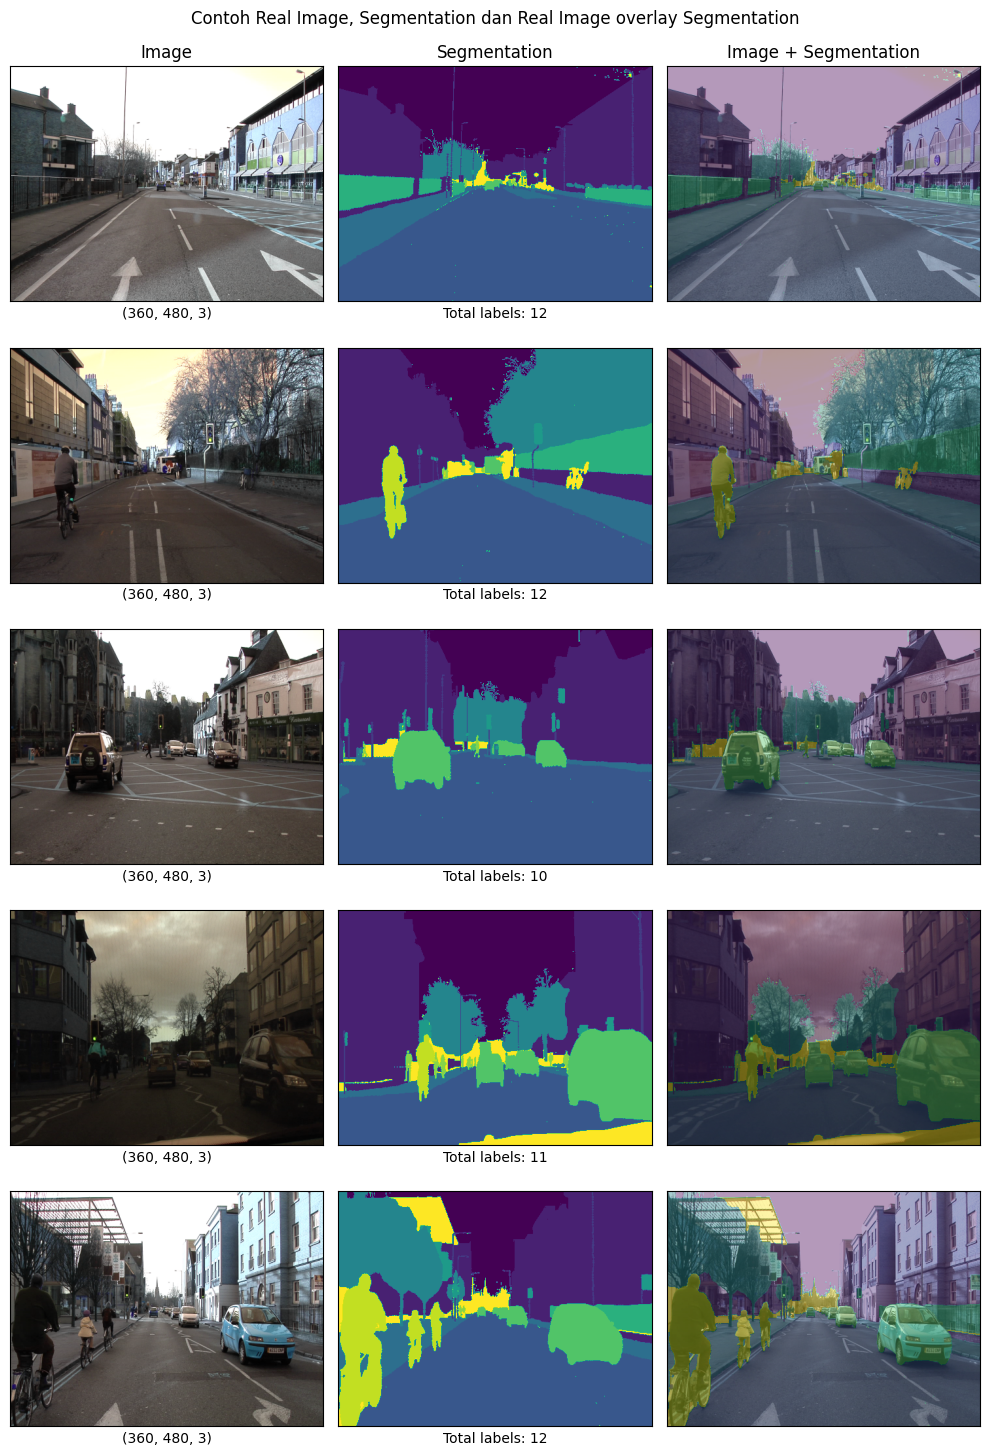

In [ ]:
# Preview Image, Mask dan Image + Mask
# Code berikut memerlukan library random dan opencv

# Print sample image + annotation

max_files = 5 # print just only 5 files from data train

fig, ax = plt.subplots(max_files, 3, figsize=(10,15))

list_annotation_train = os.listdir(JOIN_MASK)
list_image_train = os.listdir(JOIN_IMAGE)

for file in range(max_files):
    i = random.randint(1, 367)
    image = cv.imread(os.path.join(JOIN_IMAGE,
                                   list_image_train[i]))
    annotation_gray = cv.imread(os.path.join(JOIN_MASK,
                                        list_annotation_train[i]))
    annotation = cv.cvtColor(annotation_gray, cv.COLOR_BGR2GRAY)

    labels = len(np.unique(annotation))

    ax[0, 0].set_title("Image")
    ax[file, 0].imshow(image)
    ax[file, 0].set_xticks([])
    ax[file, 0].set_yticks([])
    ax[file, 0].set_xlabel(image.shape)

    ax[0, 1].set_title("Segmentation")
    ax[file, 1].imshow(annotation)
    ax[file, 1].set_xticks([])
    ax[file, 1].set_yticks([])
    ax[file, 1].set_xlabel(f"Total labels: {labels}")

    ax[file, 2].imshow(image)
    ax[file, 2].imshow(annotation, alpha=0.4)
    ax[file, 2].set_xticks([])
    ax[file, 2].set_yticks([])
    ax[0, 2].set_title("Image + Segmentation")
    plt.suptitle('Contoh Real Image, Segmentation dan Real Image overlay Segmentation')
    plt.tight_layout()

# Code from codingan kursus CV tahun 2021

### 3.6. Cek Dimensi Image dan Mask

In [ ]:
# Check All image size is same

temp_shape = []

for files in list_image_train:
    file = cv.imread(os.path.join(JOIN_IMAGE, files))
    shape = (file.shape[1], file.shape[0], file.shape[2])
    temp_shape.append(shape)

if len(set(temp_shape)) == 1:
    print("All image have a same size: ", set(temp_shape))
else:
    print("Data have a multiple size image: ")
    print(set(temp_shape))

# Code from ChatGPT

All image have a same size:  {(480, 360, 3)}


#### Dimensi Mask

In [ ]:
# Check All mask size is same

temp_shape = []

for files in list_image_train:
    file = cv.imread(os.path.join(JOIN_MASK, files))
    shape = (file.shape[1], file.shape[0], file.shape[2])
    temp_shape.append(shape)

if len(set(temp_shape)) == 1:
    print("All image have a same size: ", set(temp_shape))
else:
    print("Data have a multiple size image: ")
    print(set(temp_shape))

# Code from ChatGPT

All image have a same size:  {(480, 360, 3)}


### 3.7. Cek Jumlah Label

Total label:  12


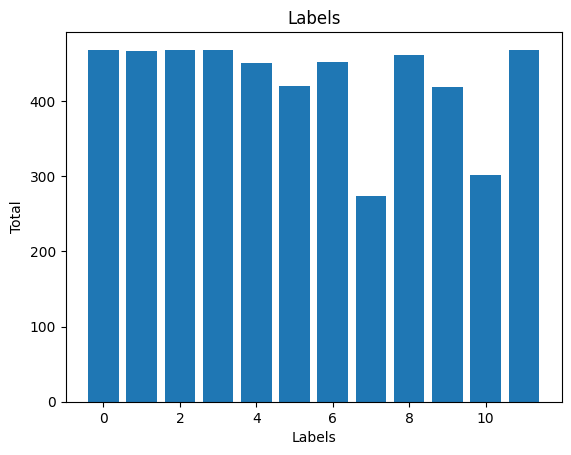

In [ ]:
# Check Total label

temp_label = []

for files in list_image_train:
    file = cv.imread(os.path.join(JOIN_MASK, files))
    label = np.unique(file)
    temp_label.append(label)

array = np.concatenate(temp_label).ravel().tolist()
array2 = np.unique(array, return_counts=True)

print("Total label: ", len(array2[0]))

plt.bar(array2[0],array2[1])
plt.xlabel('Labels')
plt.ylabel("Total")
plt.title('Labels')
plt.show()

# Code from codingan kursus CV tahun 2021

## 4 Model Training

#### Membuat List yang Berisi Jalur Image dan Mask


In [ ]:
image_path = ["/content/merged_images/"]
mask_path = ["/content/merged_mask/"]

# https://www.kaggle.com/code/oluwatobiojekanmi/carla-image-semantic-segmentation-with-u-net

#### Membuat Fungsi untuk Iterasi semua Jalur Direktori
Membuat fungsi untuk iterasi semua jalur direktori tempat data berada dan mengembalikan daftar jalur image di direktori tersebut

In [ ]:
def list_image_paths(directory_paths):
    image_paths = []
    for directory in range(len(directory_paths)):
        image_filenames = os.listdir(directory_paths[directory])
        for image_filename in image_filenames:
            image_paths.append(directory_paths[directory] + image_filename)
    return image_paths

#### Membuat List Jalur Image dan Mask dengan Menginisialisasi Fungsi di Atas

In [ ]:
image_paths = list_image_paths(image_path)
mask_paths = list_image_paths(mask_path)
number_of_images, number_of_masks = len(image_paths), len(mask_paths)
print(f"1. There are {number_of_images} images and {number_of_masks} masks in our dataset")
print(f"2. An example of an image path is: \n {image_paths[0]}")
print(f"3. An example of a mask path is: \n {mask_paths[0]}")

1. There are 468 images and 468 masks in our dataset
2. An example of an image path is: 
 /content/merged_images/0006R0_f02520.png
3. An example of a mask path is: 
 /content/merged_mask/0006R0_f02520.png


#### Membagi File Image dan Mask kedalam **training**, **validation**, dan **test** sets

In [ ]:
# First split the image paths into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, train_size=0.8, random_state=0)

# Keep part of the validation set as test set
validation_image_paths, test_image_paths, validation_mask_paths, test_mask_paths = train_test_split(val_image_paths, val_mask_paths, train_size = 0.80, random_state=0)

print(f'There are {len(train_image_paths)} images in the Training Set')
print(f'There are {len(validation_image_paths)} images in the Validation Set')
print(f'There are {len(test_image_paths)} images in the Test Set')

There are 374 images in the Training Set
There are 75 images in the Validation Set
There are 19 images in the Test Set


In [ ]:
def read_image(image_path, mask_path):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (192, 256), method='nearest')

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (192, 256), method='nearest')

    return image, mask

#### Membuat Fungsi Data Generator untuk Membaca dan Memuat Image dan Mask secara Berkelompok

In [ ]:
def data_generator(image_paths, mask_paths, buffer_size, batch_size):

    image_list = tf.constant(image_paths)
    mask_list = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().shuffle(buffer_size).batch(batch_size)

    return dataset

#### Membuat Data Pipeline untuk Data Training, Validation dan Testing Menggunakan Kedua Fungsi di Atas

In [ ]:
batch_size = 8
buffer_size = 500

train_dataset = data_generator(train_image_paths, train_mask_paths, buffer_size, batch_size)
validation_dataset = data_generator(validation_image_paths, validation_mask_paths, buffer_size, batch_size)
test_dataset = data_generator(test_image_paths, test_mask_paths, buffer_size, batch_size)

### 4.3. Membuat Fungsi Model U-Net

In [ ]:
num_classes = 12

In [ ]:
def get_unet_model():

    inputs = tf.keras.layers.Input(shape = [192, 256, 3])

    #First Downsample
    f1 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(inputs)
    b1 = tf.keras.layers.BatchNormalization()(f1)
    f2 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b1)    # Used later for residual connection

    m3 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f2)
    d4 = tf.keras.layers.Dropout(0.2)(m3)

    # Second Downsample
    f5 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d4)
    b5 = tf.keras.layers.BatchNormalization()(f5)
    f6 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b5)    # Used later for residual connection

    m7 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f6)
    d8 = tf.keras.layers.Dropout(0.2)(m7)

    # Third Downsample
    f9 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d8)
    b9 = tf.keras.layers.BatchNormalization()(f9)
    f10 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b9)    # Used later for residual connection

    m11 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f10)
    d12 = tf.keras.layers.Dropout(0.2)(m11)

    #Forth Downsample
    f13 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d12)
    b13 = tf.keras.layers.BatchNormalization()(f13)
    f14 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b13)    # Used later for residual connection

    m15 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f14)
    d16 = tf.keras.layers.Dropout(0.2)(m15)

    #Fifth Downsample
    f17 = tf.keras.layers.Conv2D(1024, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d16)
    b17 = tf.keras.layers.BatchNormalization()(f17)
    f18 = tf.keras.layers.Conv2D(1024, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b17)


    # First Upsample
    m19 = tf.keras.layers.UpSampling2D(size = (2, 2))(f18)
    d19 = tf.keras.layers.Dropout(0.2)(m19)
    c20 = tf.keras.layers.Concatenate()([d19, f14])
    f21 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1 ,activation = "relu")(c20)
    b21 = tf.keras.layers.BatchNormalization()(f21)
    f22 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b21)

    # Second Upsample
    m23 = tf.keras.layers.UpSampling2D(size = (2, 2))(f22)
    d23 = tf.keras.layers.Dropout(0.2)(m23)
    c24 = tf.keras.layers.Concatenate()([d23, f10])
    f25 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c24)
    b25 = tf.keras.layers.BatchNormalization()(f25)
    f26 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b25)

    # Third Upsample
    m27 = tf.keras.layers.UpSampling2D(size = (2, 2))(f26)
    d27 = tf.keras.layers.Dropout(0.2)(m27)
    c28 = tf.keras.layers.Concatenate()([d27, f6])
    f29 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c28)
    b29 = tf.keras.layers.BatchNormalization()(f29)
    f30 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b29)

    #Forth Upsample
    m31 = tf.keras.layers.UpSampling2D(size = (2, 2))(f30)
    d31 = tf.keras.layers.Dropout(0.2)(m31)
    c32 = tf.keras.layers.Concatenate()([d31, f2])
    f33 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c32)
    b33 = tf.keras.layers.BatchNormalization()(f33)
    f34 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b33)

    # Output Layer
    outputs = tf.keras.layers.Conv2D(num_classes, kernel_size = (3, 3), padding = "same", strides = 1, activation = "softmax")(f34)

    model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
    return model

# Ref.: https://www.kaggle.com/code/tr1gg3rtrash/car-driving-segmentation-unet-from-scratch/notebook

In [ ]:
# Assign Fungsi Model U-Net kedalam Objek model
model = get_unet_model()

### 4.4. Model Visualization & Summary

#### Visualisasi Model U-Net

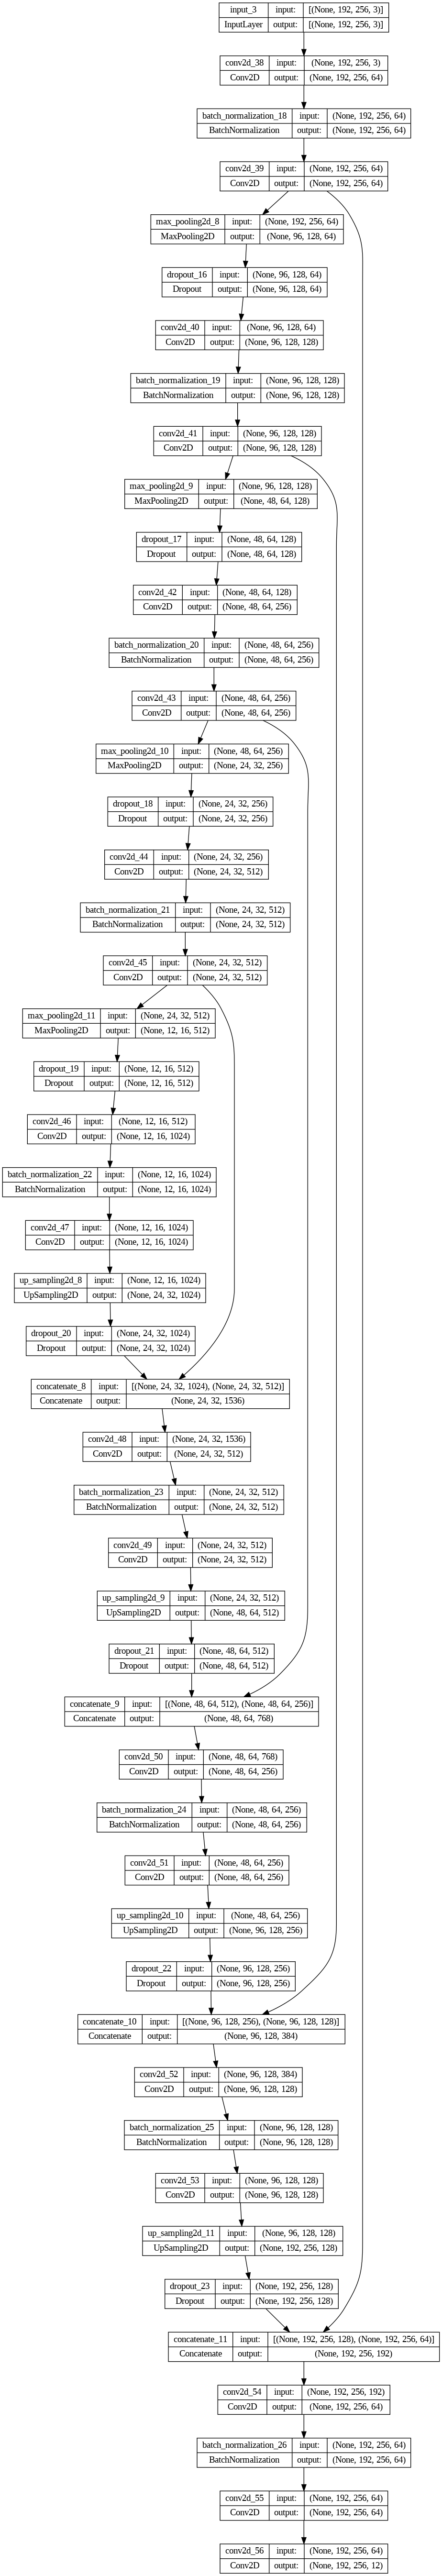

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)
# Ref.: https://www.kaggle.com/code/tr1gg3rtrash/car-driving-segmentation-unet-from-scratch/notebook

#### Model Summary

In [ ]:
# Model Summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 192, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 192, 256, 64  256        ['conv2d_38[0][0]']              
 ormalization)                  )                                                           

### 4.5. Model Training

#### Model Compiling

In [ ]:
# Compile Model
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
              metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes, name = "mean_iou")])

In [ ]:
#callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)
batch_size = 8
epochs = 100

#### Model Training

In [ ]:
# Mengukur waktu pelatihan model
import time
start_time = time.time()


# Model Training
history = model.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs = epochs,
                    verbose=1,
                    callbacks = [reduce_lr], # callbacks = [callback, reduce_lr],
                    batch_size = batch_size,
                    shuffle = True)

# Menghitung waktu pelatihan
training_time = time.time() - start_time
print("Total training time: {:.2f} seconds".format(training_time))
print("Total training time: {:.2f} hours".format(training_time/3600))

Epoch 1/100
47/47 [==============================] - 57s 737ms/step - loss: 1.0534 - accuracy: 0.6549 - mean_iou: 0.2077 - val_loss: 13.3418 - val_accuracy: 0.3194 - val_mean_iou: 0.0271 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 23s 482ms/step - loss: 0.6880 - accuracy: 0.7855 - mean_iou: 0.3167 - val_loss: 8.5809 - val_accuracy: 0.3330 - val_mean_iou: 0.0332 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 23s 481ms/step - loss: 0.5878 - accuracy: 0.8191 - mean_iou: 0.3563 - val_loss: 5.4905 - val_accuracy: 0.3363 - val_mean_iou: 0.0355 - lr: 0.0010
Epoch 4/100
47/47 [==============================] - 23s 486ms/step - loss: 0.5368 - accuracy: 0.8337 - mean_iou: 0.3895 - val_loss: 6.6361 - val_accuracy: 0.3342 - val_mean_iou: 0.0332 - lr: 0.0010
Epoch 5/100
47/47 [==============================] - 23s 485ms/step - loss: 0.5139 - accuracy: 0.8403 - mean_iou: 0.4153 - val_loss: 4.6466 - val_accuracy: 0.3787 - val_mean_iou: 0.0475 - lr: 0.0010
Epoc

### 4.6. Hasil Training

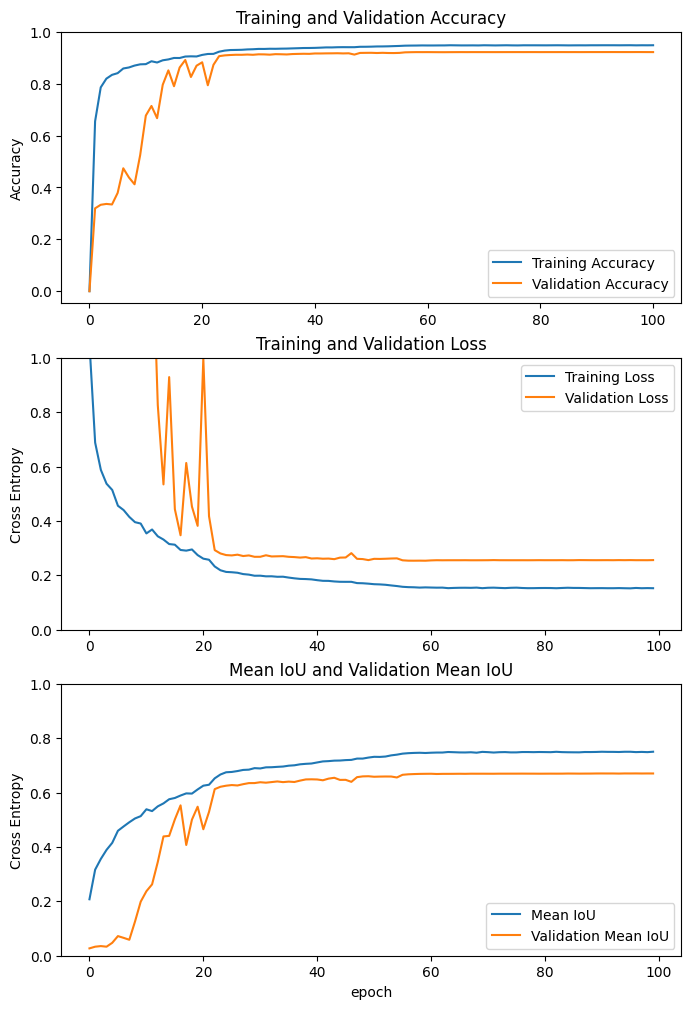

In [ ]:
# Plot training and validation metrics
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

mean_iou = history.history['mean_iou']
val_mean_iou = history.history['val_mean_iou']

plt.figure(figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')

plt.subplot(3, 1, 3)
plt.plot(mean_iou, label='Mean IoU')
plt.plot(val_mean_iou, label='Validation Mean IoU')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Mean IoU and Validation Mean IoU')

plt.xlabel('epoch')

plt.show()

# Add space between subplots
#plt.subplots_adjust(wspace=0.4)

plt.show()

# https://www.kaggle.com/code/oluwatobiojekanmi/carla-image-semantic-segmentation-with-u-net#4.-Model-Evaluation

## 5 Saving Model

In [ ]:
tf.keras.models.save_model(model, '/content/drive/MyDrive/KULIAH CV SPECIALIST/Project 3 Self Driving Car/Model/model_tf_unet_exp_1 run_1.h5')

## 6 Evaluasi Model

In [ ]:
def create_mask(dataset, model):
    true_masks, predicted_masks = [], []
    for images, masks in dataset:
        pred_masks = model.predict(images)
        pred_masks = tf.expand_dims(tf.argmax(pred_masks, axis=-1), axis=-1)
        true_masks.extend(masks)
        predicted_masks.extend(pred_masks)

    true_masks = np.array(true_masks)
    predicted_masks = np.array(predicted_masks)

    return true_masks, predicted_masks

In [ ]:
true_train_masks, predicted_train_masks = create_mask(train_dataset, model)
true_validation_masks, predicted_validation_masks = create_mask(validation_dataset, model)
true_test_masks, predicted_test_masks = create_mask(test_dataset, model)

1/1 [==============================] - 0s 22ms/step


In [ ]:
def evaluate_model(true_masks, predicted_masks, n_classes, smooth = 1e-6):

    """
    Evaluates semantic segmentation model

    Argument:
        true_masks: ground truth segmentations
        predicted_masks: predicted segmentations
        n_classes: number of segmentation classes
        smooth: a minute float digit added to denominators to avoid error from a zero division

    Returns:
        class_wise_evaluations: a dictionary containing evaluation metric
                                outputs the for each segmentation class
        overall_evaluations: a dictionary containing evaluation metric
                             outputs the for all segmentation classes
        """
    # Create empty lists to store evaluation metric outputs
    class_wise_true_positives, class_wise_true_negatives = [],[]
    class_wise_false_positives, class_wise_false_negatives = [],[]
    class_wise_precisions, class_wise_recalls = [],[]
    class_wise_specificities, class_wise_ious = [],[]
    class_wise_tdrs, class_wise_f1_scores = [],[]
    classes = []

    for clas in range(n_classes):
        true_positives, true_negatives, false_positives, false_negatives = 0,0,0,0
        precisions, recalls, specificities, ious, f1_scores, tdrs = 0,0,0,0,0,0

        number_of_masks = true_masks.shape[0]

        for mask_id in range(number_of_masks):
            true_positive = np.sum(np.logical_and(true_masks[mask_id]==clas, predicted_masks[mask_id]==clas))
            true_negative = np.sum(np.logical_and(true_masks[mask_id]!=clas, predicted_masks[mask_id]!=clas))
            false_positive = np.sum(np.logical_and(true_masks[mask_id]!=clas, predicted_masks[mask_id]==clas))
            false_negative = np.sum(np.logical_and(true_masks[mask_id]==clas, predicted_masks[mask_id]!=clas))

            true_positives += true_positive
            true_negatives += true_negative
            false_positives += false_positive
            false_negatives += false_negative

        recall = round(true_positives/(true_positives + false_negatives + smooth), 2)
        precision = round(true_positives/(true_positives + false_positives + smooth), 2)
        specificity = round(true_negatives/(true_negatives + false_positives + smooth), 2)
        tdr = round((1 - (false_negatives/(true_positives + false_negatives + smooth))), 2)
        iou = round(true_positives/(true_positives + false_negatives + false_positives + smooth), 2)
        f1_score = round((2 * precision * recall)/(precision + recall + smooth), 2)

        class_wise_true_positives.append(true_positives)
        class_wise_true_negatives.append(true_negatives)
        class_wise_false_positives.append(false_positives)
        class_wise_false_negatives.append(false_negatives)
        class_wise_recalls.append(recall)
        class_wise_precisions.append(precision)
        class_wise_specificities.append(specificity)
        class_wise_ious.append(iou)
        class_wise_tdrs.append(tdr)
        class_wise_f1_scores.append(f1_score)
        classes.append("Class " + str(clas+1))
        # class_wise_pixel_accuracies.append(pixel_accuracy)

    total_true_positives = np.sum(class_wise_true_positives)
    total_true_negatives = np.sum(class_wise_true_negatives)
    total_false_positives = np.sum(class_wise_false_positives)
    total_false_negatives = np.sum(class_wise_false_negatives)
    mean_recall = round(np.average(np.array(class_wise_recalls)), 2)
    mean_precision = round(np.average(np.array(class_wise_precisions)), 2)
    mean_specificity = round(np.average(np.array(class_wise_specificities)), 2)
    mean_iou = round(np.average(np.array(class_wise_ious)), 2)
    mean_tdr = round(np.average(np.array(class_wise_tdrs)), 2)
    mean_f1_score = round(np.average(np.array(class_wise_f1_scores)), 2)

    class_wise_evaluations = {"Class": classes,
                              "True Positive Pixels": class_wise_true_positives,
                              "True Negative Pixels": class_wise_true_negatives,
                              "False Positive Pixels": class_wise_false_positives,
                              "False Negative Pixels": class_wise_false_negatives,
                              "Recall": class_wise_recalls,
                              "Precision": class_wise_precisions,
                              "Specificity": class_wise_specificities,
                              "IoU": class_wise_ious,
                              "TDR": class_wise_tdrs,
                              "F1-Score": class_wise_f1_scores}

    overall_evaluations = {"Class": "All Classes",
                        "True Positive Pixels": total_true_positives,
                        "True Negative Pixels": total_true_negatives,
                        "False Positive Pixels": total_false_positives,
                        "False Negative Pixels": total_false_negatives,
                        "Recall": mean_recall,
                        "Precision": mean_precision,
                        "Specificity": mean_specificity,
                        "IoU": mean_iou,
                        "TDR": mean_tdr,
                        "F1-Score": mean_f1_score}

    evaluations = {"Overall Evaluations": overall_evaluations,
                   "Class-wise Evaluations": class_wise_evaluations}

    return evaluations

In [ ]:
def show_evaluations(evaluations,
                     metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1 Score"],
                     class_list=None,
                     display_evaluations="All"):
    """
    Returns a pandas dataframe containing specified metrics

        Arguments:
            evaluations: evaluation output from the evaluate_model function
            metrics: a list containing one or more of the following metrics:
                     'True Positive', 'True Negative', 'False Positive', 'False Negative',
                     'Recall', 'Precision', 'Specificity', 'F1 Score', 'IoU', 'TDR'
            display_evaluations: one of 'All' to display both overall and class-wise evaluations,
                                 'Overall' to display only the overall evaluations,
                                 'Class-wise' to display only the classwise evaluations.
            class_list: list or tuple containing names of segmentation class.
    """

    # Split evaluations into overall and class-wise evaluations
    overall_evaluations = evaluations["Overall Evaluations"]
    class_wise_evaluations = evaluations["Class-wise Evaluations"]

    # Validate list of metrics
    for metric_id in range(len(metrics)):
        metric = metrics[metric_id]
        if metric not in overall_evaluations:
            raise ValueError("'metrics argument' not properly defined. "
                            "Kindly create a list containing one or more of the following metrics: "
                             "'True Positive', 'True Negative', 'False Positive', 'False Negative', "
                             "'Recall', 'Precision', 'Specificity', 'F1 Score', 'IoU', 'TDR'")

    # Check if class_list is none
    if class_list != None and all(isinstance(class_, str) for class_ in class_list):
        if len(class_list) == len(class_wise_evaluations["Class"]):
            class_list = [class_list]
        else:
            raise ValueError("class_list argument' not properly defined. "
                             "List is either shorter or longer than segmentation classes")
    else:
        class_list = [class_wise_evaluations["Class"]]

    # Extract data from the evaluations
    overall_data = [overall_evaluations["Class"]] + [overall_evaluations[metrics[metric_id]] for metric_id in range(len(metrics))]
    classwise_data = class_list + [class_wise_evaluations[metrics[metric_id]] for metric_id in range(len(metrics))]
    overall_data = np.array(overall_data).reshape(1,-1)
    classwise_data = np.array(classwise_data).transpose()

    # Determine the type of evaluation report to display
    if display_evaluations.lower() == "all":
        data = np.concatenate((overall_data, classwise_data), axis=0)
    elif display_evaluations.lower() == "overall":
        data = overall_data
    elif display_evaluations.lower() == "class-wise" or "classwise":
        data = classwise_data
    else:
        raise ValueError("Display argument are not properly defined."
                        "Kindly use 'All' to display both overall and class-wise evaluations."
                        "Use 'Overall' to display only the overall evaluations."
                        "Or use 'Class-wise' to display only the class-wise evaluations")


    # Create evaluation report as a pandas dataframe
    dataframe = pd.DataFrame(data)
    dataframe_titles = ["Class"] + metrics
    dataframe.columns = dataframe_titles
    # dataframe = dataframe.set_index(dataframe_titles[0], col_level=1)

    return dataframe

In [ ]:
model_evaluation_on_train_dataset = evaluate_model(true_train_masks, predicted_train_masks, n_classes=12)

show_evaluations(model_evaluation_on_train_dataset,
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"],
                 class_list=None,
                 display_evaluations="All")

,Class,Recall,Precision,Specificity,IoU,TDR,F1-Score
0,All Classes,0.83,0.87,1.0,0.76,0.83,0.85
1,Class 1,0.97,0.97,0.99,0.94,0.97,0.97
2,Class 2,0.96,0.96,0.99,0.92,0.96,0.96
3,Class 3,0.32,0.68,1.0,0.27,0.32,0.44
4,Class 4,0.99,0.99,1.0,0.98,0.99,0.99
5,Class 5,0.94,0.93,1.0,0.88,0.94,0.93
6,Class 6,0.95,0.91,0.99,0.87,0.95,0.93
7,Class 7,0.72,0.82,1.0,0.62,0.72,0.77
8,Class 8,0.92,0.88,1.0,0.82,0.92,0.9
9,Class 9,0.96,0.94,1.0,0.9,0.96,0.95


In [ ]:
model_evaluation_on_validation_dataset = evaluate_model(true_validation_masks, predicted_validation_masks, n_classes=12)

show_evaluations(model_evaluation_on_validation_dataset,
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"],
                 class_list=None,
                 display_evaluations="All")

,Class,Recall,Precision,Specificity,IoU,TDR,F1-Score
0,All Classes,0.76,0.81,0.99,0.67,0.76,0.78
1,Class 1,0.97,0.95,0.99,0.92,0.97,0.96
2,Class 2,0.94,0.93,0.98,0.88,0.94,0.93
3,Class 3,0.33,0.62,1.0,0.28,0.33,0.43
4,Class 4,0.98,0.99,0.99,0.97,0.98,0.98
5,Class 5,0.9,0.88,0.99,0.8,0.9,0.89
6,Class 6,0.91,0.84,0.98,0.78,0.91,0.87
7,Class 7,0.62,0.74,1.0,0.51,0.62,0.67
8,Class 8,0.71,0.73,1.0,0.56,0.71,0.72
9,Class 9,0.93,0.91,1.0,0.85,0.93,0.92


In [ ]:


model_evaluation_on_test_dataset = evaluate_model(true_test_masks, predicted_test_masks, n_classes=12)

show_evaluations(model_evaluation_on_test_dataset,
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"],
                 class_list=None,
                 display_evaluations="All")

,Class,Recall,Precision,Specificity,IoU,TDR,F1-Score
0,All Classes,0.8,0.86,1.0,0.73,0.8,0.82
1,Class 1,0.98,0.98,1.0,0.96,0.98,0.98
2,Class 2,0.95,0.93,0.98,0.89,0.95,0.94
3,Class 3,0.24,0.63,1.0,0.21,0.24,0.35
4,Class 4,0.99,0.99,0.99,0.98,0.99,0.99
5,Class 5,0.93,0.92,1.0,0.87,0.93,0.92
6,Class 6,0.93,0.92,0.99,0.86,0.93,0.92
7,Class 7,0.65,0.81,1.0,0.56,0.65,0.72
8,Class 8,0.85,0.88,1.0,0.77,0.85,0.86
9,Class 9,0.95,0.94,1.0,0.9,0.95,0.94


#### Load Model

In [ ]:
# Menghubungkan Colab ke GDrive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# LOAD SAVED MODEL
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU # karena pada model menggunakan matrix MeanIoU

# Gantilah 'UpdatedMeanIoU' dengan nama metrik Anda
custom_objects = {'UpdatedMeanIoU': MeanIoU} # MeanIoU seperti yang digunakan di library keras

# Daftarkan metrik Anda
tf.keras.utils.get_custom_objects().update(custom_objects)

# Ganti path dengan lokasi file H5 yang berisi model Anda
model_path = '/content/drive/MyDrive/KULIAH CV SPECIALIST/Project 3 Self Driving Car/Model/model_tf_unet_exp_1 run_1.h5'

# Memuat model dari file H5
model_saya = tf.keras.models.load_model(model_path)

#### Membuat Fungsi untuk Create Mask menggunakan Model yang Sudah di Trianing

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)

    return pred_mask[0]

#### Membuat Fungsi untuk Menampilkan Output dari Proses: Suatu Input Image, Ground Truth (True Mask), dan Predicted Mask

In [ ]:
def display(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

#### Membuat Fungsi untuk Memilih Image dari Dataset Spesifik dan Mengembalikan Images, True Mask dan Predicted Mask

In [ ]:
def show_predictions(dataset, num):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model_saya.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model_saya.predict(sample_image[tf.newaxis, ...]))])